In [1]:
import pandas as pd
import pandas.io.sql as sqlio
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5, style="whitegrid")
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import numpy as np
from connector import getConnection

### Mean  index rate (monthly basis)

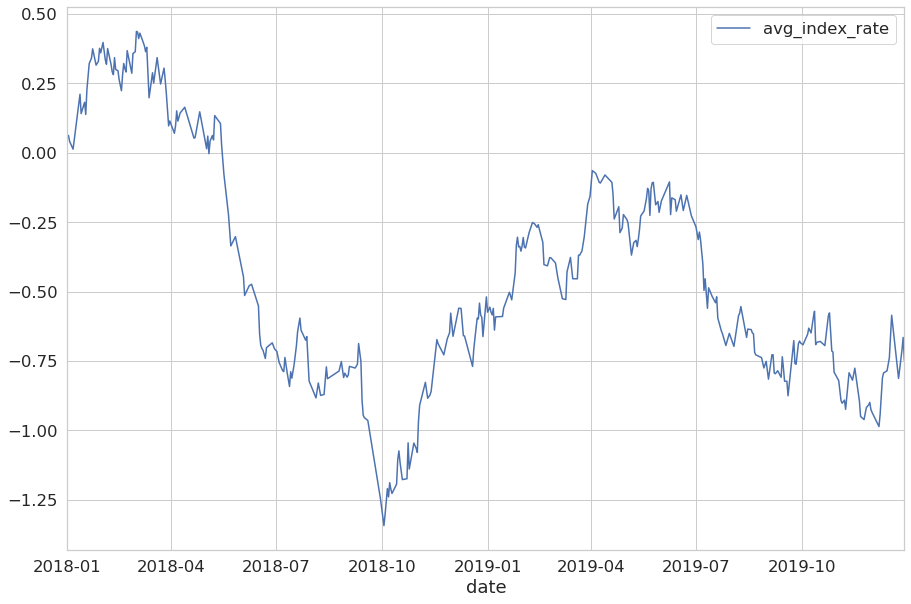

In [2]:
conn = getConnection()

sql = """
SELECT d.date ,AVG(s.index_rate) as avg_index_rate  FROM sale s, date d
WHERE s.sale_date_key = d.date_key 
GROUP BY d.date
HAVING AVG(s.index_rate) IS NOT NULL
ORDER BY d.date
"""

df = sqlio.read_sql_query(sql, conn)


conn.close()
df.head()
df.plot(kind='line',x='date',y='avg_index_rate',figsize=(15,10))



### distribution of loans on maritial status

marital_status,divorced,married,single
loan_amount,4548500.0,22495500.0,10891000.0


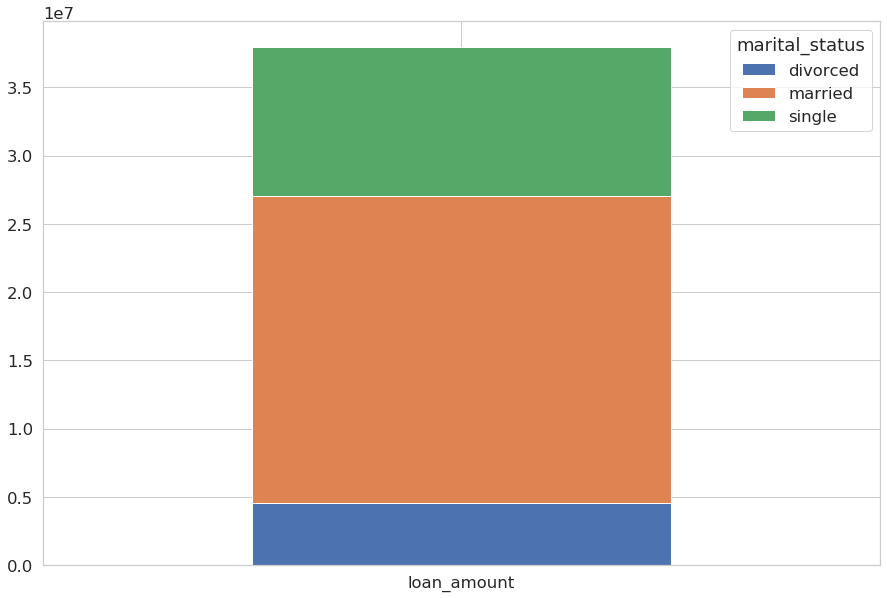

In [3]:
conn = getConnection()

sql = """
SELECT c.marital_status , SUM(s.loan_amount) as loan_amount  FROM sale s, customer c
WHERE s.customer_key = c.customer_key
GROUP BY c.marital_status
"""

df = sqlio.read_sql_query(sql, conn)

df = df.set_index('marital_status')
df = df.transpose()

df.plot.bar(stacked=True,figsize=(15,10), rot = 0)
conn.close()
df.head()



### Distribution of loans by age

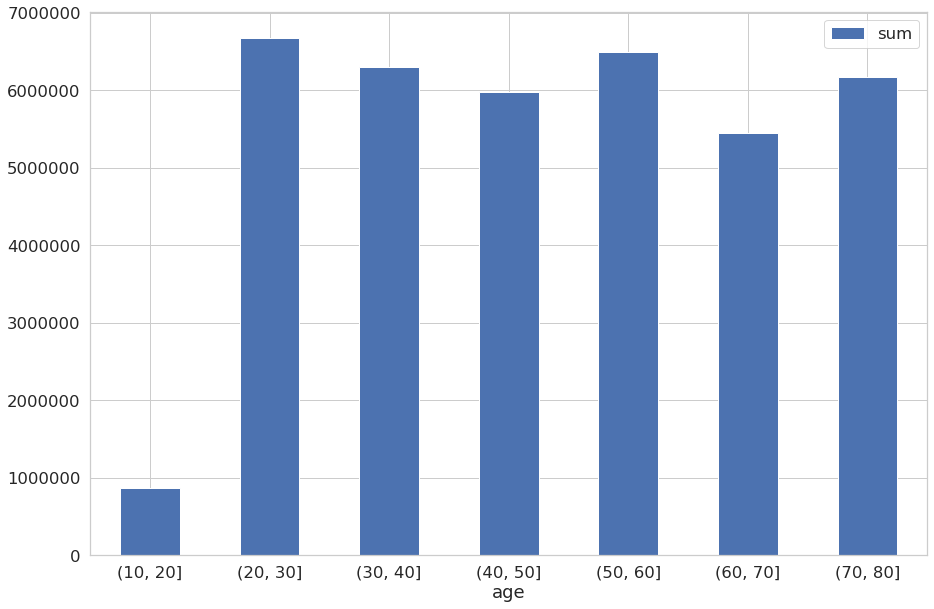

In [4]:
conn = getConnection()

sql = """
SELECT (2020 - c.birth_year) as age ,SUM( s.loan_amount)as loan_amount
FROM sale s, customer c
WHERE s.customer_key = c.customer_key
GROUP BY AGE
"""

df = sqlio.read_sql_query(sql, conn)
bins = pd.cut(df['age'], [10, 20, 30,40,50,60,70,80])
df = df.groupby(bins)['loan_amount'].agg(['sum'])
conn.close()
df.head()
df.plot.bar(figsize=(15,10), rot = 0)



### Distribution by job

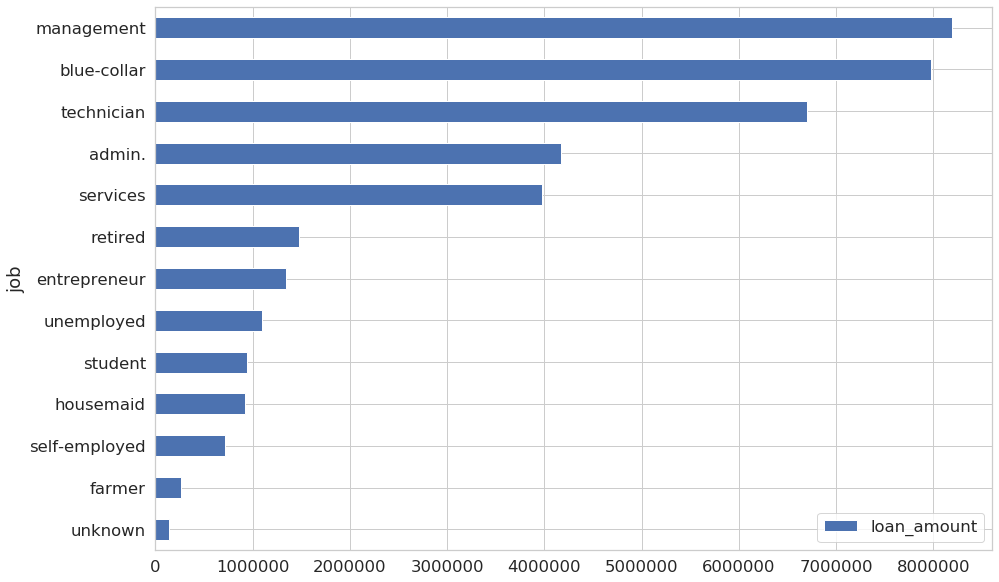

In [5]:
conn = getConnection()

sql = """
SELECT c.job ,SUM( s.loan_amount)as loan_amount
FROM sale s, customer c
WHERE s.customer_key = c.customer_key
GROUP BY c.job
ORDER BY loan_amount
"""

df = sqlio.read_sql_query(sql, conn)
#bins = pd.cut(df['age'], [0, 20, 40, 60,80])
#df = df.groupby(bins)['loan_amount'].agg(['sum'])
df = df.set_index('job')
conn.close()
df.head()
df.plot.barh(figsize=(15,10), rot = 0)

### number of customer with  loan

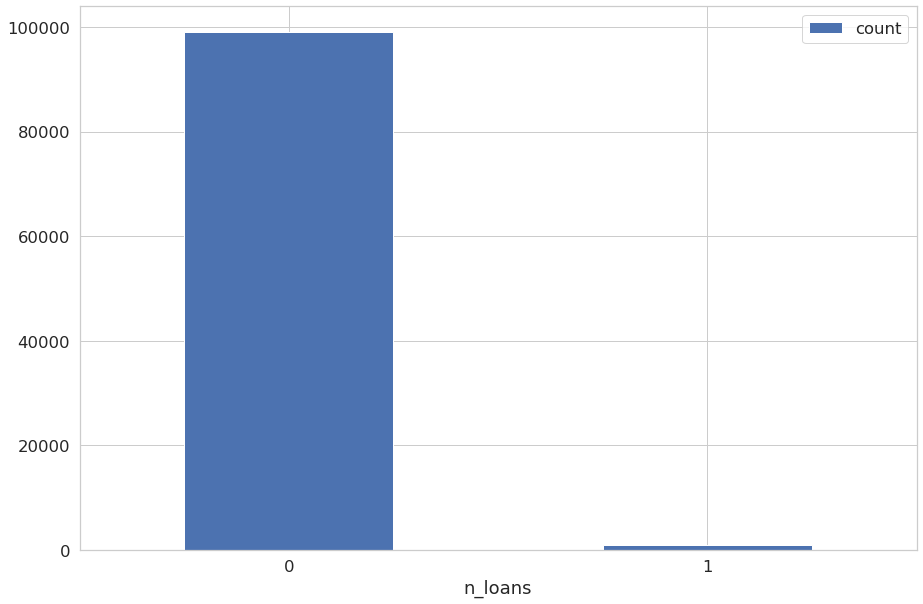

In [7]:
conn = getConnection()

sql = """
select num_loans.n_loans, count(*)
from
(SELECT c.customer_key ,COUNT( s.loan_amount)as n_loans
FROM customer c left outer join sale s on  s.customer_key = c.customer_key
GROUP BY c.customer_key
ORDER BY n_loans desc) 
 num_loans 
GROUP BY num_loans.n_loans

"""

df = sqlio.read_sql_query(sql, conn)
df = df.set_index('n_loans')
conn.close()
df.head()
df.plot.bar(figsize=(15,10), rot = 0)

### Distribution of loans on currency

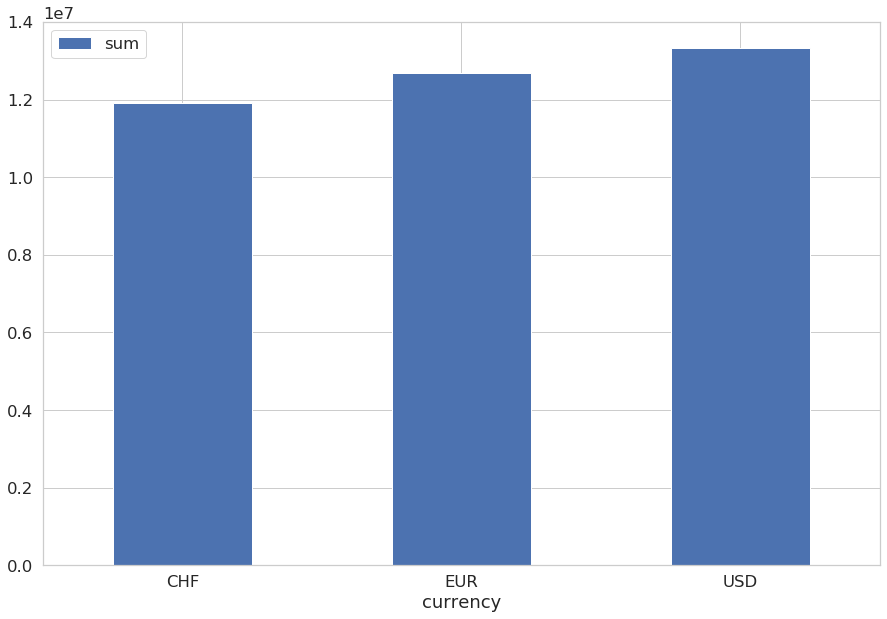

In [18]:
conn = getConnection()

sql = """
SELECT p.currency ,SUM(s.loan_amount)    
FROM sale s, product p    
WHERE p.product_key = s.product_key   
GROUP BY  p.currency; 
"""

df = sqlio.read_sql_query(sql, conn)
conn.close()
df = df.set_index('currency')
df.head()

df.plot.bar(figsize=(15,10), rot = 0)


### Distribution loans in region

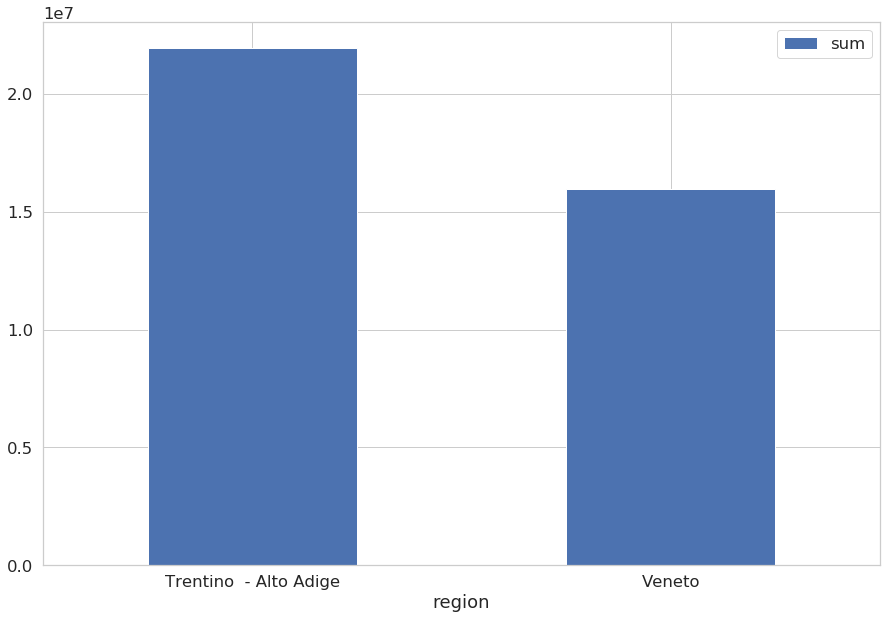

In [10]:
conn = getConnection()

sql = """
select * from (
SELECT b.region ,SUM(s.loan_amount)    
FROM sale s, branch b, product p    
WHERE s.branch_key = b.branch_key AND p.product_key = s.product_key   
GROUP BY  b.region) aaaa
; 
"""

df = sqlio.read_sql_query(sql, conn)
conn.close()
df = df.set_index('region')
df.head()

df.plot.bar(figsize=(15,10), rot = 0)
#display(df)


### distribuition of loans by province

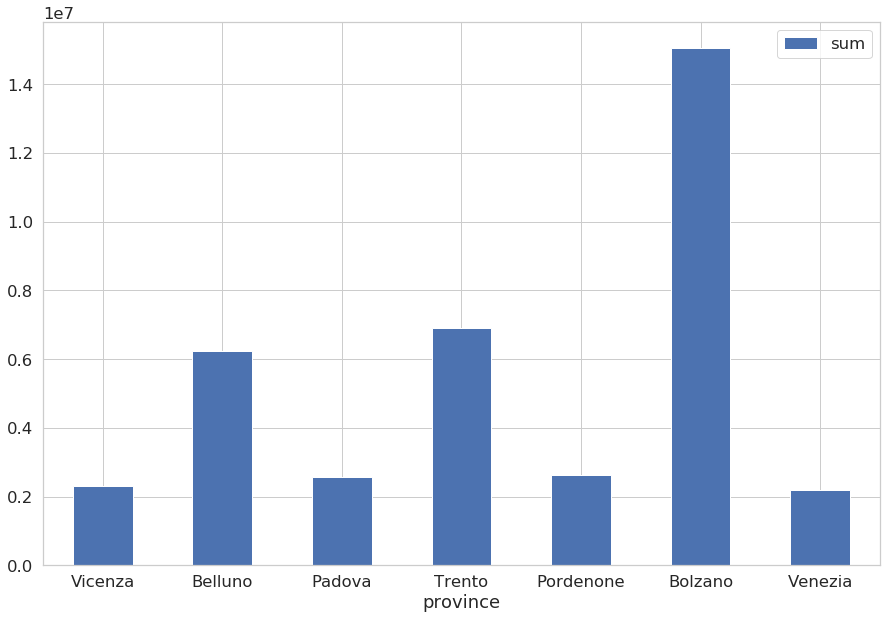

In [13]:
conn = getConnection()

sql = """
select * from (
SELECT b.province ,SUM(s.loan_amount)    
FROM sale s, branch b, product p    
WHERE s.branch_key = b.branch_key AND p.product_key = s.product_key   
GROUP BY  b.province
) aaaa
; 
"""

df = sqlio.read_sql_query(sql, conn)
conn.close()
df = df.set_index('province')
df.head()

df.plot.bar(figsize=(15,10), rot = 0)
#display(df)


### distribuition of loans by province in 2018,2019

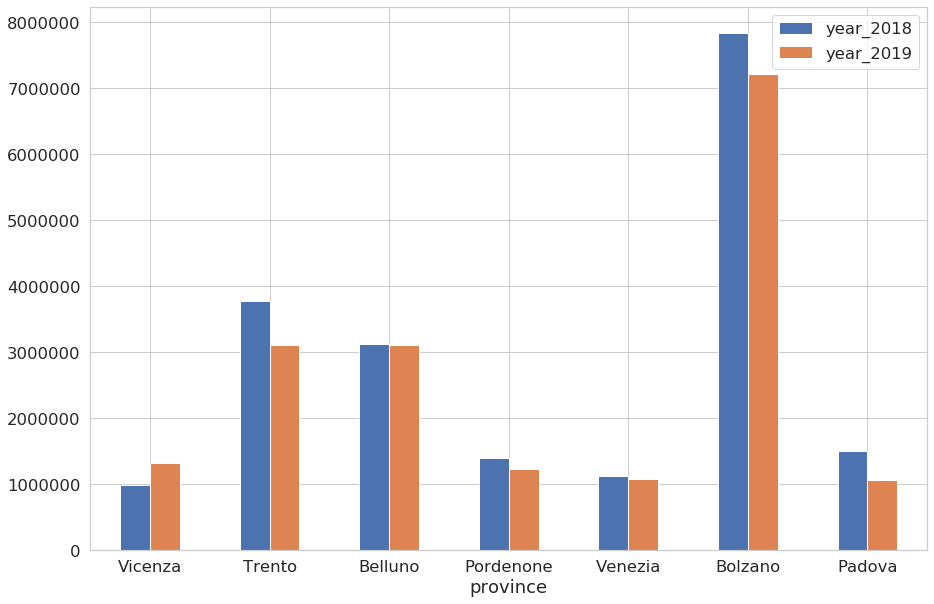

In [19]:
conn = getConnection()

sql = """
WITH p_y_data AS (
SELECT b.province , d.year, SUM(s.loan_amount) as loan_amount
FROM sale s, branch b, date d  
WHERE s.branch_key = b.branch_key AND s.sale_date_key = d.date_key
GROUP BY  b.province, d.year) 
select a.province, a.loan_amount AS year_2018, b.loan_amount AS year_2019 from p_y_data a,   p_y_data b
 where a.year = 2018 AND b.year = 2019 AND
 a.province = b.province
; 
"""

df = sqlio.read_sql_query(sql, conn)
conn.close()
df = df.set_index('province')
df.head()

df.plot.bar(figsize=(15,10), rot = 0)
#display(df)


### cumilative sale

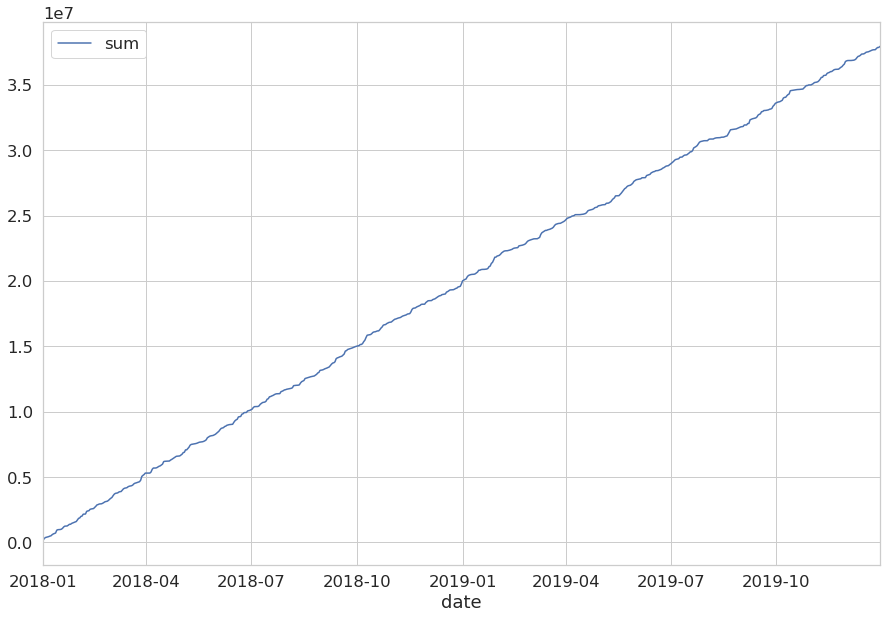

In [21]:
conn = getConnection()

sql = """
SELECT date, sum(sale.loan_amount) OVER (ORDER BY date) FROM sale, date
where sale.sale_date_key = date.date_key
;
"""

df = sqlio.read_sql_query(sql, conn)


conn.close()
df.head()
df.plot(kind='line',x='date',figsize=(15,10))